In [1]:
from tqdm import tqdm
import torch
import numpy as np
import seaborn as sns
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch import inference_mode
from torch.nn import Linear, BCEWithLogitsLoss
from torch.utils.data import random_split, DataLoader
from torchvision.models.regnet import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights

import sys
sys.path.append("../")
from utils import CustomDataset

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
weights = RegNet_Y_3_2GF_Weights.IMAGENET1K_V2
model = regnet_y_3_2gf(weights=weights)

In [4]:
data = CustomDataset("../Data/processed_metadata.csv", "../Data/images", "filename", ['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila', 'E.Coli', 'Fungal', 'H1N1', 'Herpes ', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Unknown', 'Varicella', 'Viral', 'todo'])

train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    data, [train_size, val_size, test_size]
)

In [5]:
train_dataset.__len__(), test_dataset.__len__(), val_dataset.__len__()

(650, 187, 92)

In [6]:
train_loader = DataLoader(train_dataset, 16, shuffle=True)
test_loader = DataLoader(test_dataset, 16, shuffle=True)
val_loader = DataLoader(val_dataset, 16, shuffle=True)

In [7]:
num_classes = 28
in_features = model.fc.in_features
model.fc = Linear(in_features, num_classes)

In [8]:
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [16]:
def TrainLoop(
    model,
    optimizer:torch.optim.Optimizer,
    criterion:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    test_dataloader:torch.utils.data.DataLoader,
    val_dataloader:torch.utils.data.DataLoader=None,
    num_epochs:int=20,
    early_stopping_rounds:int=5,
    device:str='cpu'
):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    total_train_loss = []
    total_val_loss = []
    total_test_loss = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print("Epoch {}\n----------".format(epoch))
        train_loss = 0
        for i, (batch, label) in enumerate(train_dataloader):
            batch, label = batch.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, label.float())
            train_loss += loss
            loss.backward()
            optimizer.step()
            print("Loss for batch {} = {}".format(i, loss))

        print("\nTraining Loss for epoch {} = {}\n".format(epoch, train_loss))
        total_train_loss.append(train_loss)

        if val_dataloader is not None:
            model.eval()
            validation_loss = 0
            with inference_mode():
                for batch, label in val_dataloader:
                    batch, label = batch.to(device), label.to(device)
                    outputs = model(batch)
                    loss = criterion(outputs, label.float())
                    validation_loss += loss

                if validation_loss < best_val_loss:
                    best_val_loss = validation_loss
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                print(f"Current Validation Loss = {validation_loss}")
                print(f"Best Validation Loss = {best_val_loss}")
                print(f"Epochs without Improvement = {epochs_without_improvement}")

            if epochs_without_improvement > early_stopping_rounds:
                print("Early Stoppping Triggered")
                break
            total_val_loss.append(validation_loss)

        model.eval()
        test_loss = 0
        with inference_mode():
            for batch, label in test_dataloader:
                batch, label = batch.to(device), label.to(device)
                outputs = model(batch)
                loss = criterion(outputs, label.float())
                test_loss += loss

            print("\nTest Loss for epoch {} = {}".format(epoch, test_loss))
        total_test_loss.append(test_loss)

    x = np.arange(num_epochs)

    total_train_loss = [item.cpu().detach().numpy() for item in total_train_loss]
    total_test_loss = [item.cpu().detach().numpy() for item in total_test_loss]
    total_val_loss = [item.cpu().detach().numpy() for item in total_val_loss]

    total_train_loss = np.array(total_train_loss)
    total_test_loss = np.array(total_test_loss)
    total_val_loss = np.array(total_val_loss)

    sns.lineplot(x=x, y=total_train_loss, label='Training Loss')
    sns.lineplot(x=x, y=total_test_loss, label='Testing Loss')
    sns.lineplot(x=x, y=total_val_loss, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(np.arange(num_epochs))
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0
----------
Loss for batch 0 = 0.11183170229196548
Loss for batch 1 = 0.08993189036846161
Loss for batch 2 = 0.08040136098861694
Loss for batch 3 = 0.11336643993854523
Loss for batch 4 = 0.0781579315662384
Loss for batch 5 = 0.10161498188972473
Loss for batch 6 = 0.11274845153093338
Loss for batch 7 = 0.08110902458429337
Loss for batch 8 = 0.15285202860832214
Loss for batch 9 = 0.15698273479938507
Loss for batch 10 = 0.07358360290527344
Loss for batch 11 = 0.1034596860408783
Loss for batch 12 = 0.11266954243183136
Loss for batch 13 = 0.117063008248806
Loss for batch 14 = 0.06813296675682068
Loss for batch 15 = 0.10952690988779068
Loss for batch 16 = 0.10210137814283371
Loss for batch 17 = 0.11046429723501205
Loss for batch 18 = 0.14540186524391174
Loss for batch 19 = 0.17224039137363434
Loss for batch 20 = 0.17195656895637512
Loss for batch 21 = 0.09562350809574127
Loss for batch 22 = 0.1809607595205307
Loss for batch 23 = 0.11593160033226013
Loss for batch 24 = 0.11456090956926

 50%|█████     | 1/2 [01:08<01:08, 68.97s/it]


Test Loss for epoch 0 = 1.5907599925994873
Epoch 1
----------
Loss for batch 0 = 0.11243212968111038
Loss for batch 1 = 0.12190528959035873
Loss for batch 2 = 0.10671792179346085
Loss for batch 3 = 0.147940993309021
Loss for batch 4 = 0.07489853352308273
Loss for batch 5 = 0.0816974863409996
Loss for batch 6 = 0.13539621233940125
Loss for batch 7 = 0.11022158712148666
Loss for batch 8 = 0.1315450668334961
Loss for batch 9 = 0.07606887817382812
Loss for batch 10 = 0.08033546805381775
Loss for batch 11 = 0.12284907698631287
Loss for batch 12 = 0.0908457338809967
Loss for batch 13 = 0.10230600088834763
Loss for batch 14 = 0.04396815225481987
Loss for batch 15 = 0.14032188057899475
Loss for batch 16 = 0.1177341639995575
Loss for batch 17 = 0.14732800424098969
Loss for batch 18 = 0.08596144616603851
Loss for batch 19 = 0.10498157888650894
Loss for batch 20 = 0.17764459550380707
Loss for batch 21 = 0.08434794098138809
Loss for batch 22 = 0.1370786428451538
Loss for batch 23 = 0.116577103734

100%|██████████| 2/2 [02:19<00:00, 69.94s/it]


Test Loss for epoch 1 = 1.3920133113861084


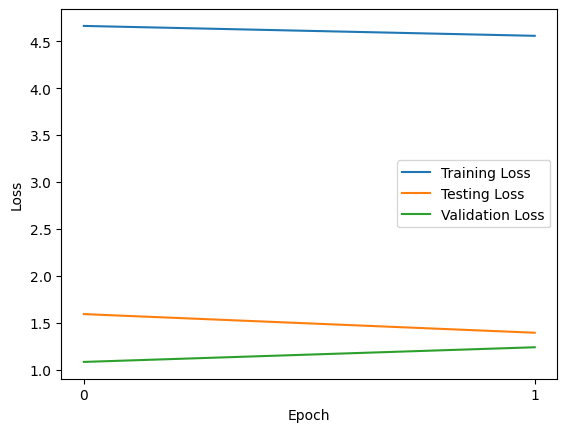

In [17]:
TrainLoop(model, optimizer, criterion, train_loader, test_loader, val_loader, device='cuda', num_epochs=2, early_stopping_rounds=1)

In [18]:
torch.cuda.empty_cache()